In [3]:
from __future__ import absolute_import, division, print_function
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from keras import layers
from keras import optimizers
from keras.callbacks import RemoteMonitor # 공부하기
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.applications.inception_v3 import preprocess_input
import os
import random
import collections
from collections import defaultdict
from shutil import copy
from shutil import copytree, rmtree
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as img

# Check the extracted dataset folder

# Helper function to download data and extract

def get_data_extract():
    if "food-101" in os.listdir('D:/subin'):
        print("Dataset already exists")
    else: # 존재하면 다운 X
        tf.keras.utils.get_file(
        'food-101.tar.gz',
        'http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz',
        cache_subdir='D:/subin',
        extract=True,
        archive_format='tar',
        cache_dir=None
        )
        print("Dataset downloaded and extracted!")

get_data_extract()

print(os.listdir('D:/subin/food-101/'))

Dataset already exists
['bestmodel_3class.hdf5', 'history_101.log', 'history_3.log', 'images', 'license_agreement.txt', 'meta', 'predict', 'README.txt', 'test', 'test_mini', 'train', 'trainedmodel_3class.hdf5', 'train_mini']


In [2]:
# tensorflow gpu 구동 확인
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.client import device_lib

print(tf.__version__)
print(keras.__version__)
print(device_lib.list_local_devices())

2.3.0
2.4.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10058536794459765180
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 12353107809991727430
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3127299278
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12393725050041567350
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 4039908792621124997
physical_device_desc: "device: XLA_GPU device"
]


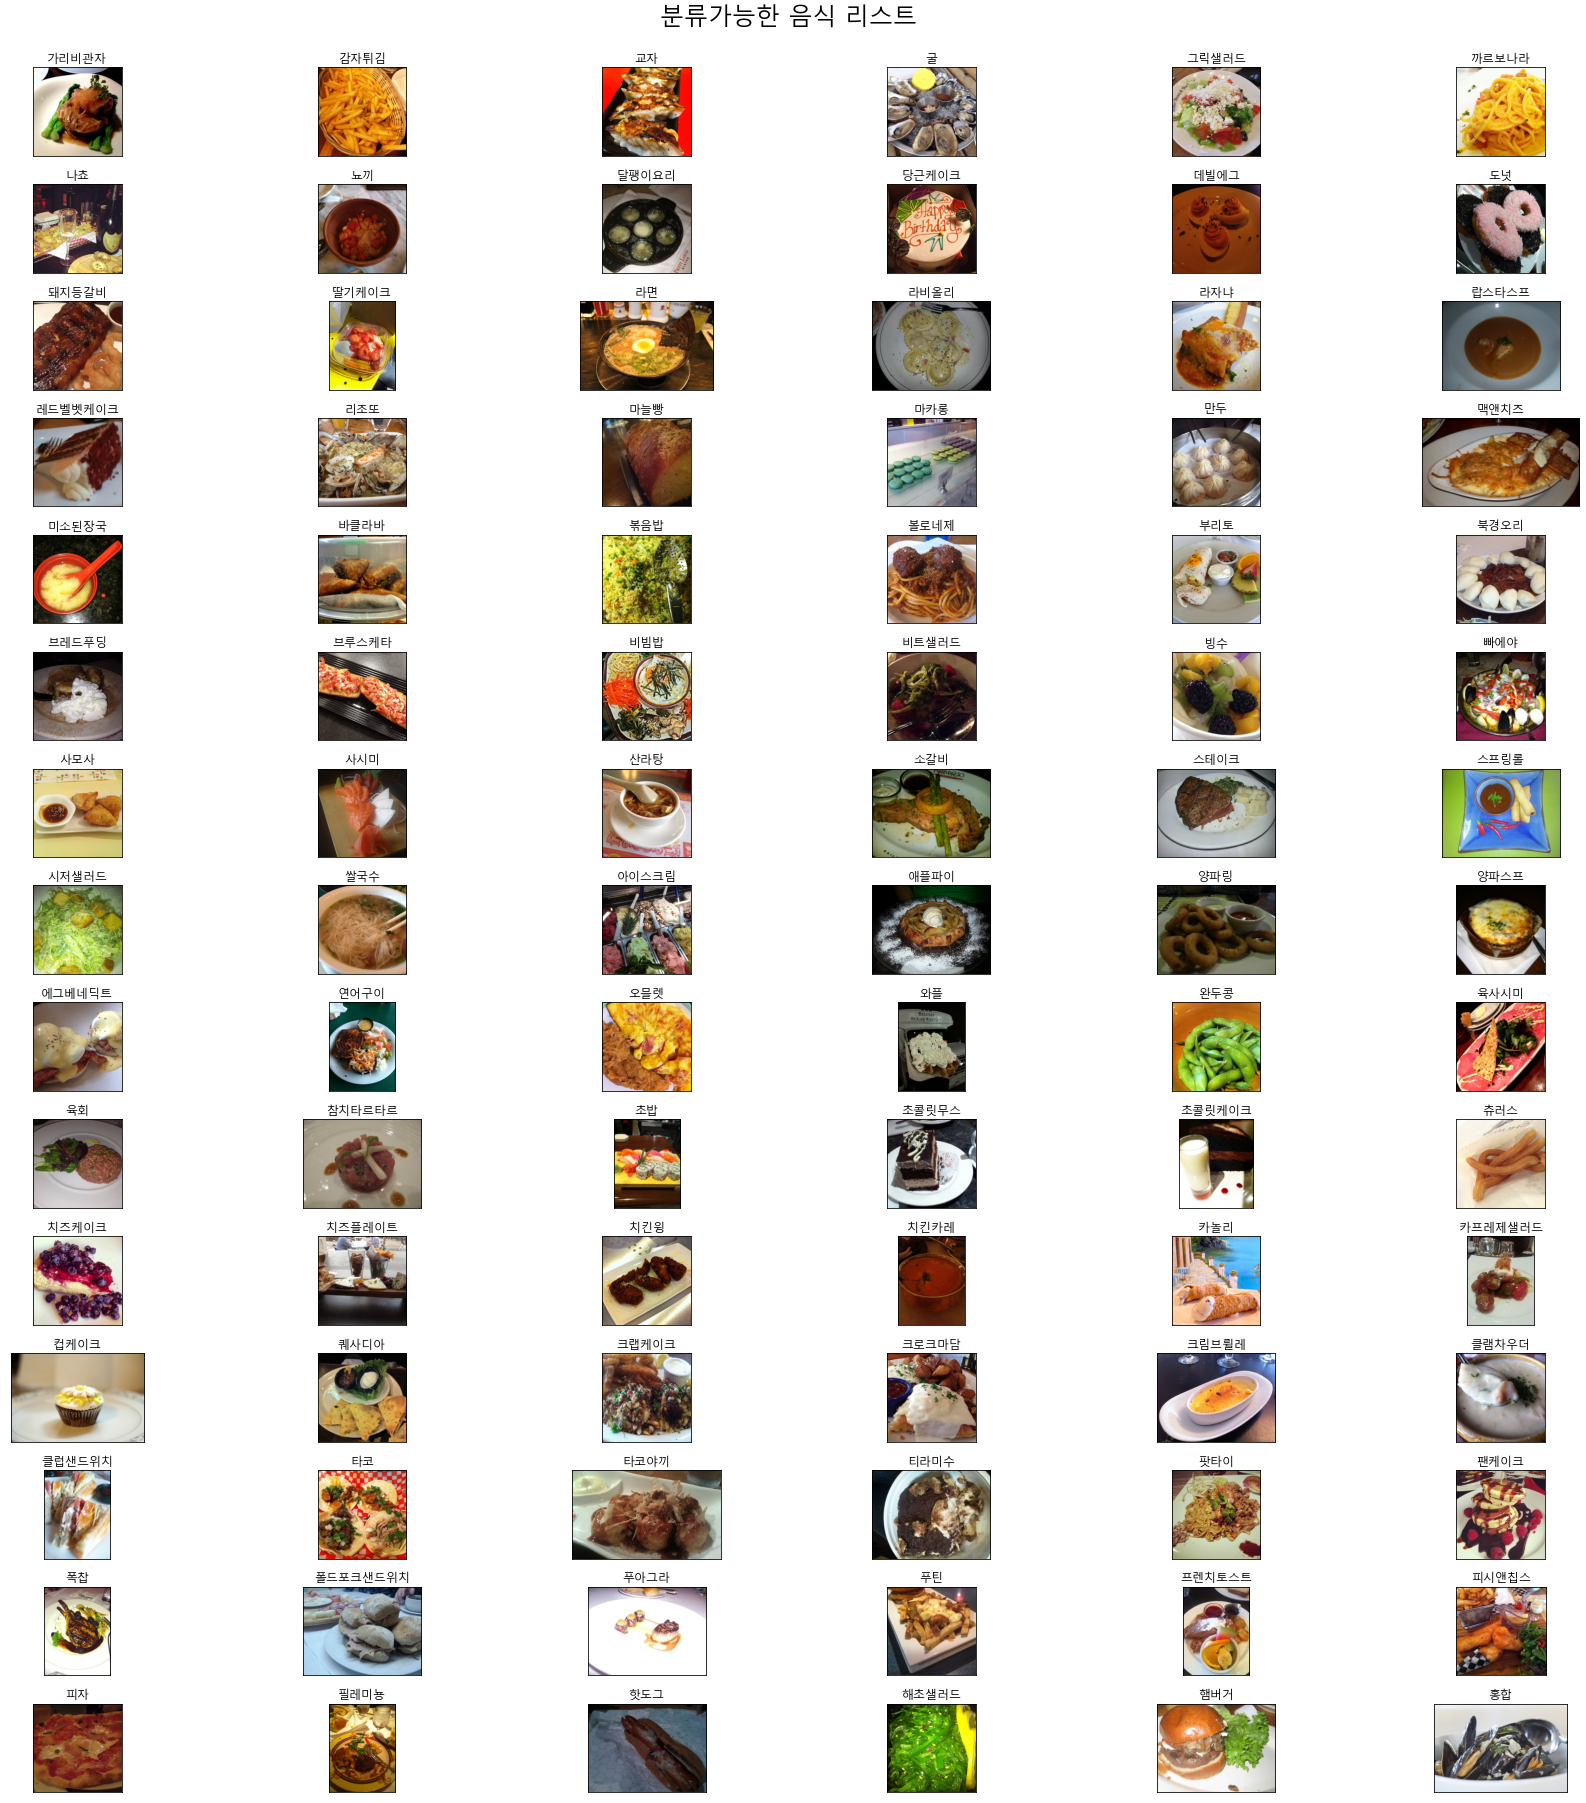

In [37]:
# Visualize the data, showing one image per class from 101 classes
rows = 15
cols = 6
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
fig.suptitle("분류가능한 음식 리스트", y=1.0, fontsize=24)
data_dir = "D:/subin/food-101/images/"
foods_sorted = sorted(os.listdir(data_dir))
food_id = 0
for i in range(rows):
    for j in range(cols):
        try:
            food_selected = foods_sorted[food_id] 
            food_id += 1
        except:
            break
        food_selected_images = os.listdir(os.path.join(data_dir,food_selected)) 
        food_selected_random = np.random.choice(food_selected_images)
        img = plt.imread(os.path.join(data_dir,food_selected, food_selected_random))
        ax[i][j].imshow(img)
        ax[i][j].set_title(food_selected, pad = 5)
    
plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()

In [92]:
# txt파일을 통해 이미지 복사
def prepare_data(filepath, src, dest):
    classes_images = defaultdict(list)
    with open(filepath, 'r', encoding='UTF8') as txt:
        paths = [read.strip() for read in txt.readlines()]
        for p in paths:
            food = p.split('/')
            classes_images[food[0]].append(food[1] + '.jpg')

    for food in classes_images.keys():
        print("\nCopying images into ",food)
        if not os.path.exists(os.path.join(dest,food)):
            os.makedirs(os.path.join(dest,food))
        for i in classes_images[food]:
            copy(os.path.join(src,food,i), os.path.join(dest,food,i))
        print("Copying Done!")

foods_sorted = sorted(os.listdir('D:/subin/food-101/images/'))
print(foods_sorted, len(foods_sorted))

# train.txt를 사용해 train데이터 분할
print("Creating train data...")
prepare_data('D:/subin/food-101/meta/train.txt', 'D:/subin/food-101/images', 'D:/subin/food-101/train')

# test.txt를 이용해 test데이터 분할
print("Creating test data...")
prepare_data('D:/subin/food-101/meta/test.txt', 'D:/subin/food-101/images', 'D:/subin/food-101/test')

# train, test 경로 저장
src_train = 'D:/subin/food-101/train'
src_test = 'D:/subin/food-101/test'

['가리비관자', '감자튀김', '교자', '굴', '그릭샐러드', '까르보나라', '나쵸', '뇨끼', '달팽이요리', '당근케이크', '데빌에그', '도넛', '돼지등갈비', '딸기케이크', '라면', '라비올리', '라자냐', '레드벨벳케이크', '리조또', '마늘빵', '마카롱', '만두', '맥앤치즈', '미소된장국', '바클라바', '볶음밥', '볼로네제', '부리토', '북경오리', '브레드푸딩', '브루스케타', '비빔밥', '비스크', '비트샐러드', '빙수', '빠에야', '사모사', '사시미', '산라탕', '소갈비', '스테이크', '스프링롤', '시저샐러드', '쌀국수', '아이스크림', '애플파이', '양파링', '양파스프', '에그베네딕트', '연어구이', '오믈렛', '와플', '완두콩', '육사시미', '육회', '참치타르타르', '초밥', '초콜릿무스', '초콜릿케이크', '츄러스', '치즈케이크', '치즈플레이트', '치킨윙', '치킨카레', '카놀리', '카프레제샐러드', '컵케이크', '퀘사디아', '크랩케이크', '크로크마담', '크림브륄레', '클램차우더', '클럽샌드위치', '타코', '타코야끼', '티라미수', '팟타이', '팬케이크', '폭찹', '폴드포크샌드위치', '푸아그라', '푸틴', '프렌치토스트', '피시앤칩스', '피자', '필레미뇽', '핫도그', '해초샐러드', '햄버거', '홍합', '후무스'] 91


In [39]:
# 무작위로 정한 음식 데이터 폴더에 저장
def dataset_mini(food_list, src, dest):
  if os.path.exists(dest):
    rmtree(dest) # removing dataset_mini(if it already exists) folders so that we will have only the classes that we want
  os.makedirs(dest)
  for food_item in food_list :
    print("Copying images into",food_item)
    copytree(os.path.join(src,food_item), os.path.join(dest,food_item))

# 무작위 추출
def pick_n_random_classes(n):
  random.seed(9000)
  food_list = []
  random_food_indices = random.sample(range(len(foods_sorted)),n) # We are picking n random food classes
  for i in random_food_indices:
    food_list.append(foods_sorted[i])
  food_list.sort()
  print("These are the randomly picked food classes we will be training the model on...\n", food_list)
  return food_list

# 훈련시킬 음식 개수 정하기
n = 91
food_list = pick_n_random_classes(n) # 101가지 중 무작위 추출

# print("Creating train data folder with new classes")
# dataset_mini(food_list, src_train, dest_train)

# print("Creating test data folder with new classes")
# dataset_mini(food_list, src_test, dest_test)

# 사용할 Train, Test 개수 체크
print("Total number of samples in train folder")
train_files = sum([len(files) for i, j, files in os.walk("D:/subin/food-101/train_mini")])
print(train_files)

print("Total number of samples in test folder")
test_files = sum([len(files) for i, j, files in os.walk("D:/subin/food-101/test_mini")])
print(test_files)

These are the randomly picked food classes we will be training the model on...
 ['가리비관자', '감자튀김', '교자', '굴', '그릭샐러드', '까르보나라', '나쵸', '뇨끼', '달팽이요리', '당근케이크', '데빌에그', '도넛', '돼지등갈비', '딸기케이크', '라면', '라비올리', '라자냐', '랍스타스프', '레드벨벳케이크', '리조또', '마늘빵', '마카롱', '만두', '맥앤치즈', '미소된장국', '바클라바', '볶음밥', '볼로네제', '부리토', '북경오리', '브레드푸딩', '브루스케타', '비빔밥', '비트샐러드', '빙수', '빠에야', '사모사', '사시미', '산라탕', '소갈비', '스테이크', '스프링롤', '시저샐러드', '쌀국수', '아이스크림', '애플파이', '양파링', '양파스프', '에그베네딕트', '연어구이', '오믈렛', '와플', '완두콩', '육사시미', '육회', '참치타르타르', '초밥', '초콜릿무스', '초콜릿케이크', '츄러스', '치즈케이크', '치즈플레이트', '치킨윙', '치킨카레', '카놀리', '카프레제샐러드', '컵케이크', '퀘사디아', '크랩케이크', '크로크마담', '크림브륄레', '클램차우더', '클럽샌드위치', '타코', '타코야끼', '티라미수', '팟타이', '팬케이크', '폭찹', '폴드포크샌드위치', '푸아그라', '푸틴', '프렌치토스트', '피시앤칩스', '피자', '필레미뇽', '핫도그', '해초샐러드', '햄버거', '홍합', '후무스']
Total number of samples in train folder
68436
Total number of samples in test folder
22936


# food_list 저장
- 예측때 사용

In [93]:
# food_list 저장
food_df = pd.DataFrame(foods_sorted)
food_df.to_csv("food_list")
food_df.columns = ['food']
food_df

,food
0,가리비관자
1,감자튀김
2,교자
3,굴
4,그릭샐러드
...,...
86,핫도그
87,해초샐러드
88,햄버거
89,홍합


# model 생성
- 함수형 모델
- inceptionV3 모델 사용

In [9]:
def train_model(n_classes,num_epochs, nb_train_samples,nb_validation_samples):
    K.clear_session()
    img_width, img_height = 299, 299
    train_data_dir = 'D:/subin/food-101/train_mini'
    validation_data_dir = 'D:/subin/food-101/test_mini'
    batch_size = 20
    bestmodel_path = 'bestmodel_'+str(n_classes)+'class.hdf5'
    trainedmodel_path = 'trainedmodel_'+str(n_classes)+'class.hdf5'
    history_path = 'history_'+str(n_classes)+'.log'

    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        shuffle=True,
        class_mode='categorical')

    validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        shuffle=True,
        class_mode='categorical')


    inception = InceptionV3(weights='imagenet', include_top=False, input_tensor=layers.Input(shape=(299, 299, 3)))
   #inception.trainable = False # 가중치 동결
    x = inception.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256,activation='relu')(x)
    x = Dropout(0.5)(x)
    pre = Dense(n_classes, activation='softmax')(x) #kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

    model = Model(inputs=inception.input, outputs=pre)
    model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
    checkpoint = ModelCheckpoint(filepath=bestmodel_path, verbose=1, save_best_only=True)
    early_stopping_callback = EarlyStopping(monitor='val_loss', patience=4)

    history = model.fit_generator(train_generator,
                                   steps_per_epoch = nb_train_samples // batch_size,
                                   validation_data=validation_generator,
                                   validation_steps=nb_validation_samples // batch_size,
                                   epochs=num_epochs,
                                   verbose=1,
                                   callbacks=[checkpoint, early_stopping_callback])

    model.save(trainedmodel_path)
    class_map = train_generator.class_indices
    
    return history, class_map

In [11]:
# 91개 이미지 데이터
n_classes = n
epochs = 300
nb_train_samples = train_files
nb_validation_samples = test_files

history, class_map_101 = train_model(n_classes, epochs, nb_train_samples, nb_validation_samples)
print(class_map_101)

Found 68436 images belonging to 91 classes.
Found 22936 images belonging to 91 classes.
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/300
3421/3421 [==============================] - ETA: 0s - loss: 4.2408 - accuracy: 0.0795
Epoch 00001: val_loss improved from inf to 3.37085, saving model to bestmodel_91class.hdf5
3421/3421 [==============================] - 2523s 738ms/step - loss: 4.2408 - accuracy: 0.0795 - val_loss: 3.3709 - val_accuracy: 0.3080
Epoch 2/300
3421/3421 [==============================] - ETA: 0s - loss: 3.2122 - accuracy: 0.2708
Epoch 00002: val_loss improved from 3.37085 to 2.11568, saving model to bestmodel_91class.hdf5
3421/3421 [==============================] - 2410s 704ms/step - loss: 3.2122 - accuracy: 0.2708 - val_loss: 2.1157 - val_accuracy: 0.5269
Epoch 3/300
3421/3421 [==============================] - ETA: 0s - loss: 2.4817 - accuracy: 0.4097
Epoch 00003: val_loss improved from 2.11568 to 1.54224, saving model to bestm

Epoch 24/300
3421/3421 [==============================] - ETA: 0s - loss: 0.5364 - accuracy: 0.8605
Epoch 00024: val_loss did not improve from 0.60382
3421/3421 [==============================] - 2380s 696ms/step - loss: 0.5364 - accuracy: 0.8605 - val_loss: 0.6082 - val_accuracy: 0.8408
Epoch 25/300
3421/3421 [==============================] - ETA: 0s - loss: 0.5151 - accuracy: 0.8651
Epoch 00025: val_loss did not improve from 0.60382
3421/3421 [==============================] - 2357s 689ms/step - loss: 0.5151 - accuracy: 0.8651 - val_loss: 0.6104 - val_accuracy: 0.8419
Epoch 26/300
3421/3421 [==============================] - ETA: 0s - loss: 0.4830 - accuracy: 0.8738
Epoch 00026: val_loss did not improve from 0.60382
3421/3421 [==============================] - 2358s 689ms/step - loss: 0.4830 - accuracy: 0.8738 - val_loss: 0.6235 - val_accuracy: 0.8394
Epoch 27/300
3421/3421 [==============================] - ETA: 0s - loss: 0.4621 - accuracy: 0.8784
Epoch 00027: val_loss did not imp

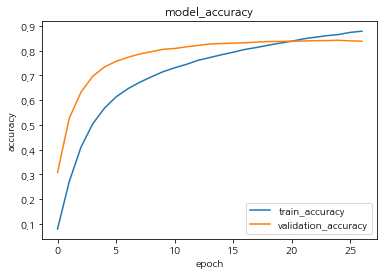

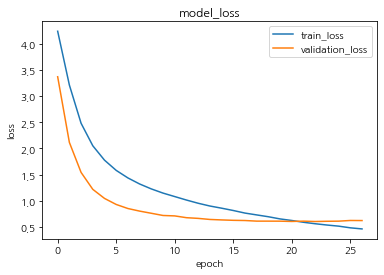

In [12]:
# 그래프로 출력
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()


def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()


plot_accuracy(history,'model_accuracy')
plot_loss(history,'model_loss')

# 이미지 예측

In [94]:
from keras.models import load_model
import pandas as pd

K.clear_session()
model_best = load_model('bestmodel_91class.hdf5',compile = False)

food_df = pd.read_csv('food_list')
food_df = food_df.drop('Unnamed: 0', axis=1)
food_df.columns = ['food']
food_df

,food
0,가리비관자
1,감자튀김
2,교자
3,굴
4,그릭샐러드
...,...
86,핫도그
87,해초샐러드
88,햄버거
89,홍합


In [35]:
model_best.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [89]:
def pred_image(img, show = True):
    for img in images:
        img = image.load_img(img, target_size=(299, 299))
        img = image.img_to_array(img)                    
        img = np.expand_dims(img, axis=0)         
        img = preprocess_input(img)
        img = img.reshape(1, 299, 299, 3)

        pred = model_best.predict(img)
        index = np.argmax(pred)
        pred_value = food_df['food'][index]
    
        plt.subplot(1, 2, 1)
        plot_pred(pred, pred_value, img)
        plt.subplot(1, 2, 2)
        plot_pred_conf(pred, index)
        plt.figure()

def plot_pred(pred_prob, pred_label, img):
    plt.imshow(img[0]*1.2)
    set
    plt.title("{} {:2.0f}%".format(pred_label, np.max(pred_prob)*100))
    
def plot_pred_conf(pred_prob, pred_label):
    top_10_pred_indexes = pred_prob.argsort()[0, -10:][::-1] # argsort 작은값부터 순서대로
    top_10_pred_values = pred_prob[0, top_10_pred_indexes]
    top_10_pred_labels = food_df.iloc[top_10_pred_indexes]['food']
    
    top_plot = plt.bar(np.arange(len(top_10_pred_labels)), 
                       top_10_pred_values, 
                       color="grey")
    plt.xticks(np.arange(len(top_10_pred_labels)),
               labels=top_10_pred_labels,
               rotation="vertical")
    
    if True:
        top_plot[np.argmax(pred_label)].set_color("green")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

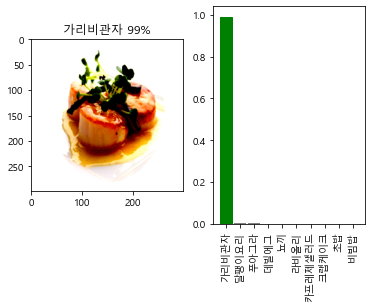

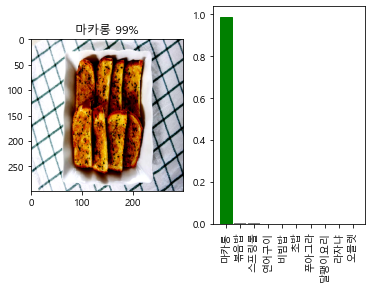

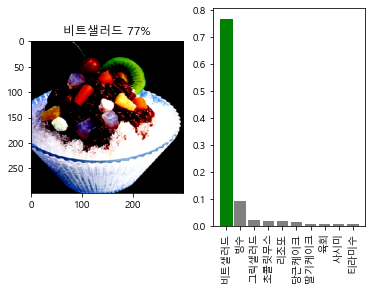

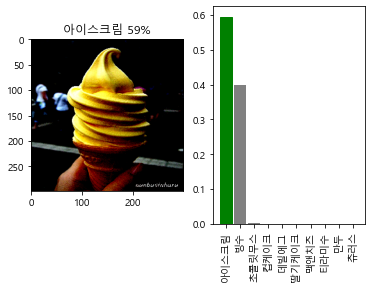

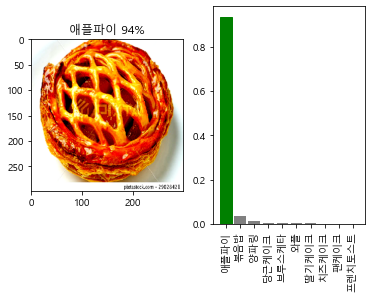

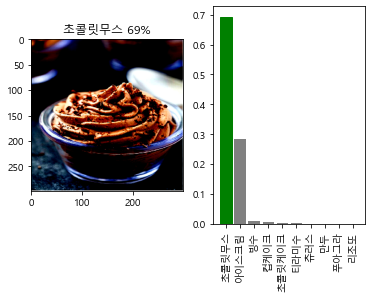

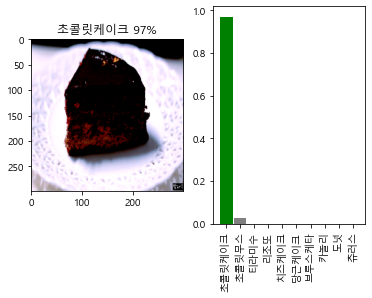

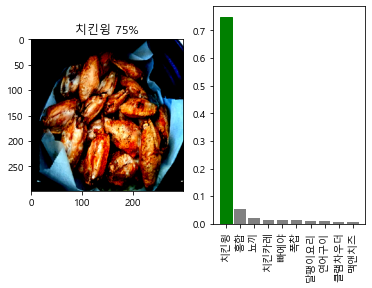

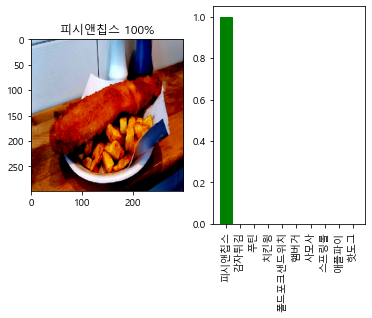

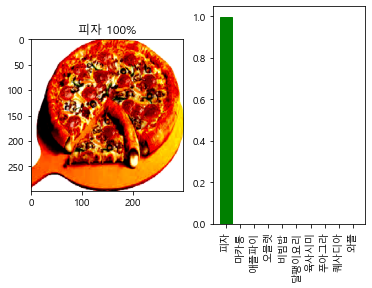

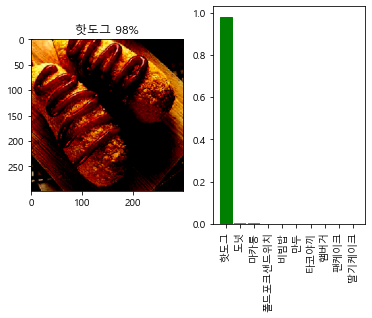

<Figure size 432x288 with 0 Axes>

In [96]:
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)


images = []
path = os.path.join(os.getcwd(), 'D:/subin/food-101/predict')
filenames = os.listdir(path)

for filename in filenames:    
    path = os.path.join('D:/subin/food-101/predict', filename)
    images.append(path)

pred_image(images, True)